# Health Data Science Text Classification Pipeline

## Import Necessary Libraries

In [1]:
!pip install shap
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import spacy
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature extraction and evaluation tools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# tqdm for progress bars
from tqdm.notebook import tqdm
tqdm.pandas()  # enables progress_apply

# For parallel processing of text cleaning
from joblib import Parallel, delayed
import multiprocessing

# For inline plotting (JupyterLab)
%matplotlib inline

## 1. Loading Data and Preprocessing Labels

In [3]:
# Read cleaned files
import pandas as pd
train_df = pd.read_csv("medical_abstracts_train_cleaned.csv")
val_df   = pd.read_csv("medical_abstracts_val_cleaned.csv")
test_df  = pd.read_csv("medical_abstracts_test_cleaned.csv")

# Compare original and cleaned text for the first document
print("\nComparison for the first document:")
print("\nOriginal:", train_df['text'].iloc[0][:200], "...")
print("\nCleaned:", train_df['clean_text'].iloc[0][:200], "...\n")


Comparison for the first document:

Original: Comparison of FRTL-5 cell growth in vitro with that of xenotransplanted cells and the thyroid of the recipient mouse. The present work was designed to compare in vitro cell growth kinetics with in viv ...

Cleaned: comparison cell growth vitro xenotransplante cell thyroid recipient mouse present work design compare vitro cell growth kinetic vivo growth condition similar possible labeling purpose cell culture mon ...



In [ ]:
#Calculating and determining no. of CPUs to use for parallel processing (currently set to half of available CPUs)
''' 
Note: If you know how many CPU cores are safe to use,
replace "max(1, multiprocessing.cpu_count() // 2)" with the 
no. of cores you want to deploy
'''
n_cores = max(1, multiprocessing.cpu_count() // 2)
print(f"Using {n_cores} CPU cores for parallel processing")

#Processing text
def medical_preprocessing(text):
    nlp = spacy.load("en_core_sci_sm", disable=['ner', 'parser'])
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() 
        for token in doc
        if not token.is_stop 
        and not token.is_punct 
        and len(token.text) > 2 
        and token.is_alpha
    ]
    return " ".join(tokens)

def process_texts_in_parallel(texts, n_jobs):
    """Process texts in parallel using joblib."""
    return Parallel(n_jobs=n_jobs)(
        delayed(medical_preprocessing)(text) for text in tqdm(texts)
    )

# Test on a sample
sample_text = train_df['text'].iloc[0]
print("Original text (first 200 chars):")
print(sample_text[:200], "...\n")
print("Preprocessed text (first 200 chars):")
print(medical_preprocessing(sample_text)[:200], "...\n")

# Apply preprocessing to all datasets
print("\nPreprocessing training set...")
train_df['clean_text'] = process_texts_in_parallel(train_df['text'], n_cores)
print("Preprocessing validation set...")
val_df['clean_text'] = process_texts_in_parallel(val_df['text'], n_cores)
print("Preprocessing test set...")
test_df['clean_text'] = process_texts_in_parallel(test_df['text'], n_cores)

print("\nPreprocessing complete!")

train_df.to_csv("medical_abstracts_train_cleaned.csv", index=False)
val_df.to_csv("medical_abstracts_val_cleaned.csv", index=False)
test_df.to_csv("medical_abstracts_test_cleaned.csv", index=False)

# Compare original and cleaned text for the first document
print("\nComparison for the first document:")
print("Original:", train_df['text'].iloc[0][:200], "...")
print("Cleaned:", train_df['clean_text'].iloc[0][:200], "...\n")

# Display text length statistics
train_df['original_length'] = train_df['text'].str.len()
train_df['cleaned_length'] = train_df['clean_text'].str.len()
print("Original text length statistics:")
print(train_df['original_length'].describe())
print("\nCleaned text length statistics:")
print(train_df['cleaned_length'].describe())

In [1]:
# Read cleaned files
import pandas as pd
train_df = pd.read_csv("medical_abstracts_train_cleaned.csv")
val_df   = pd.read_csv("medical_abstracts_val_cleaned.csv")
test_df  = pd.read_csv("medical_abstracts_test_cleaned.csv")

# Compare original and cleaned text for the first document
print("\nComparison for the first document:")
print("Original:", train_df['text'].iloc[0][:200], "...")
print("Cleaned:", train_df['clean_text'].iloc[0][:200], "...\n")

In [2]:
# Compare original and cleaned text for the first document
print("\nComparison for the first document:")
print("Original:", train_df['text'].iloc[0][:200], "...")
print("Cleaned:", train_df['clean_text'].iloc[0][:200], "...\n")


Comparison for the first document:
Original: Comparison of FRTL-5 cell growth in vitro with that of xenotransplanted cells and the thyroid of the recipient mouse. The present work was designed to compare in vitro cell growth kinetics with in viv ...
Cleaned: comparison cell growth vitro xenotransplante cell thyroid recipient mouse present work design compare vitro cell growth kinetic vivo growth condition similar possible labeling purpose cell culture mon ...



## 3. Exploratory Data Analysis (EDA) – Word Clouds and N-gram Analysis


Generating EDA visuals...


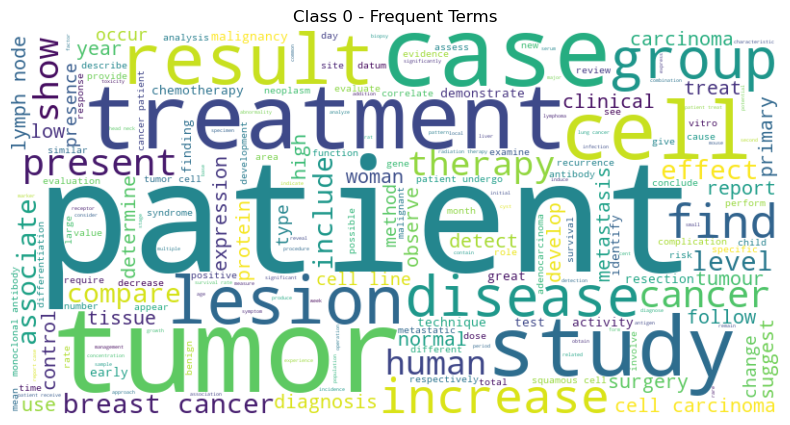

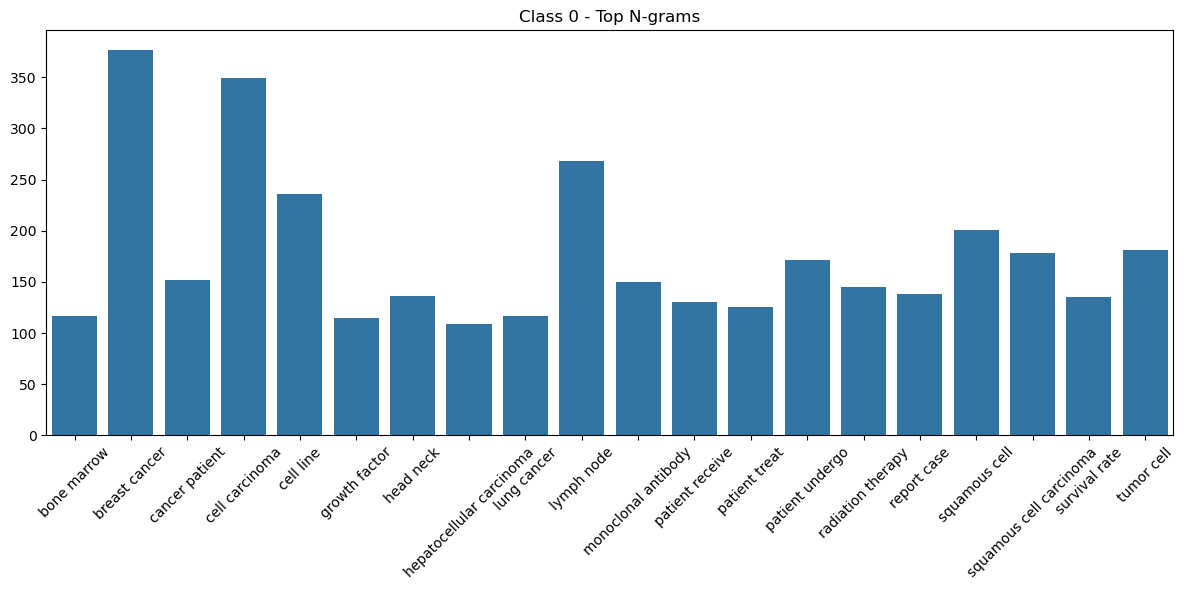

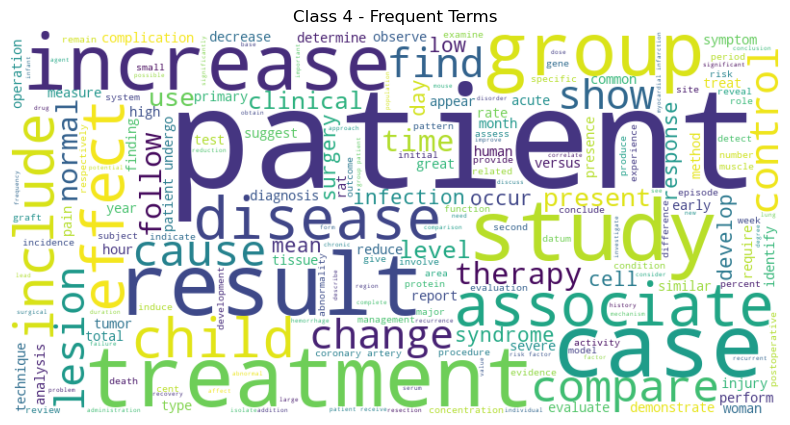

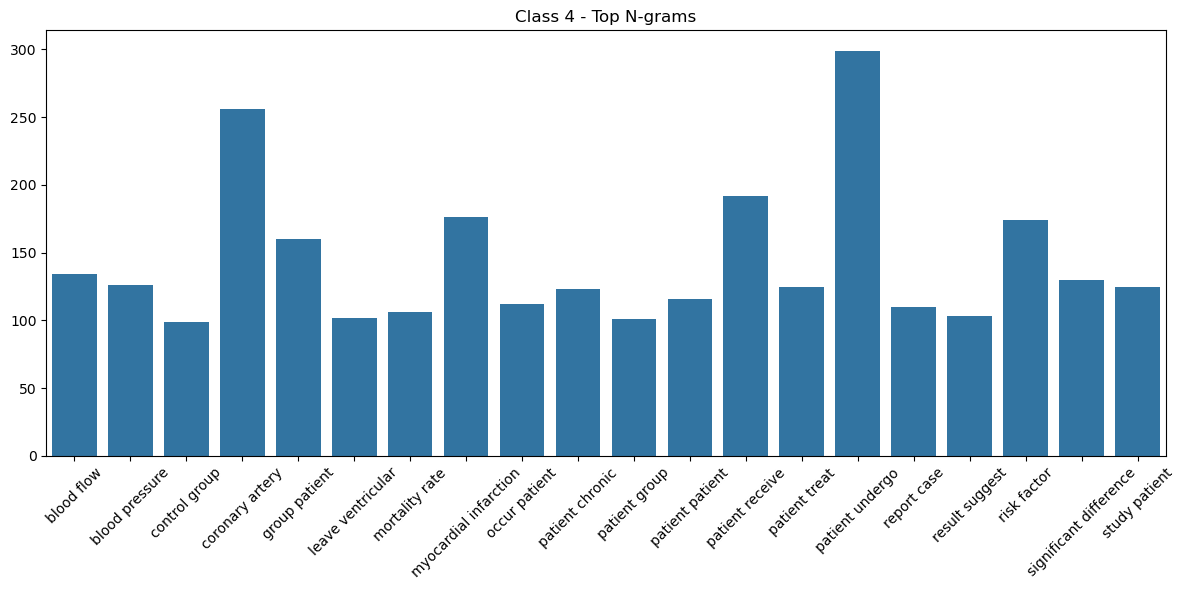

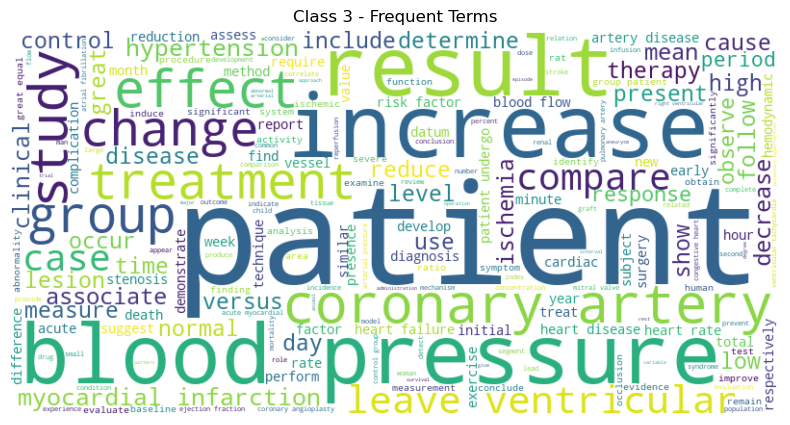

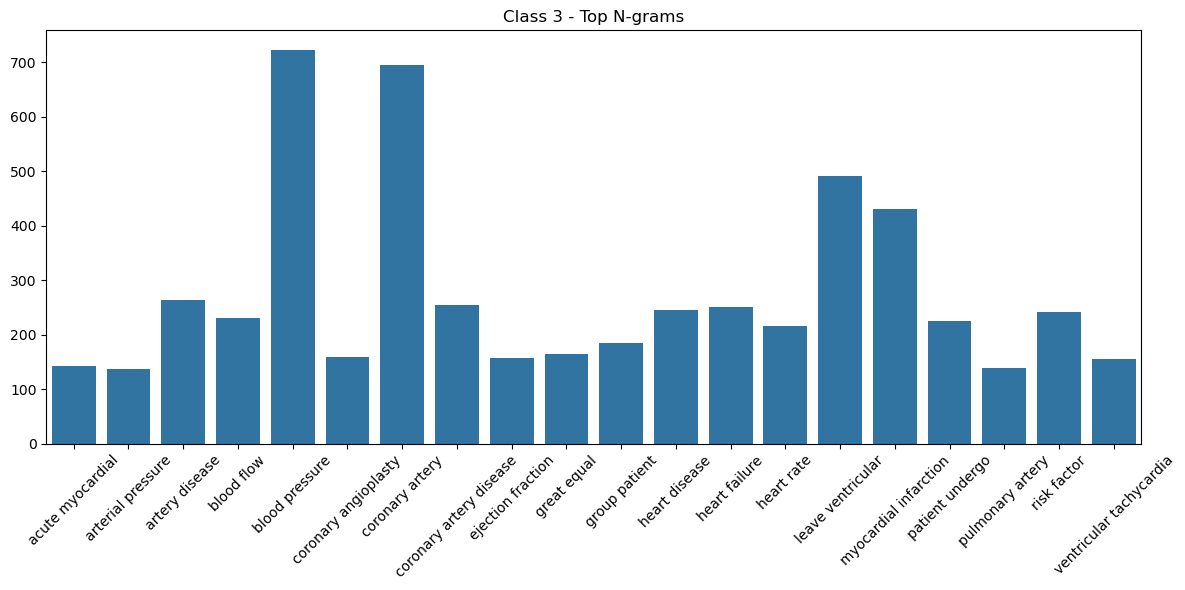

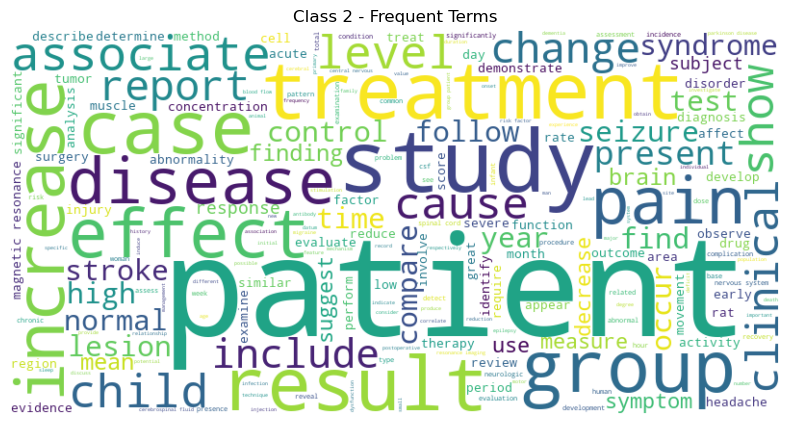

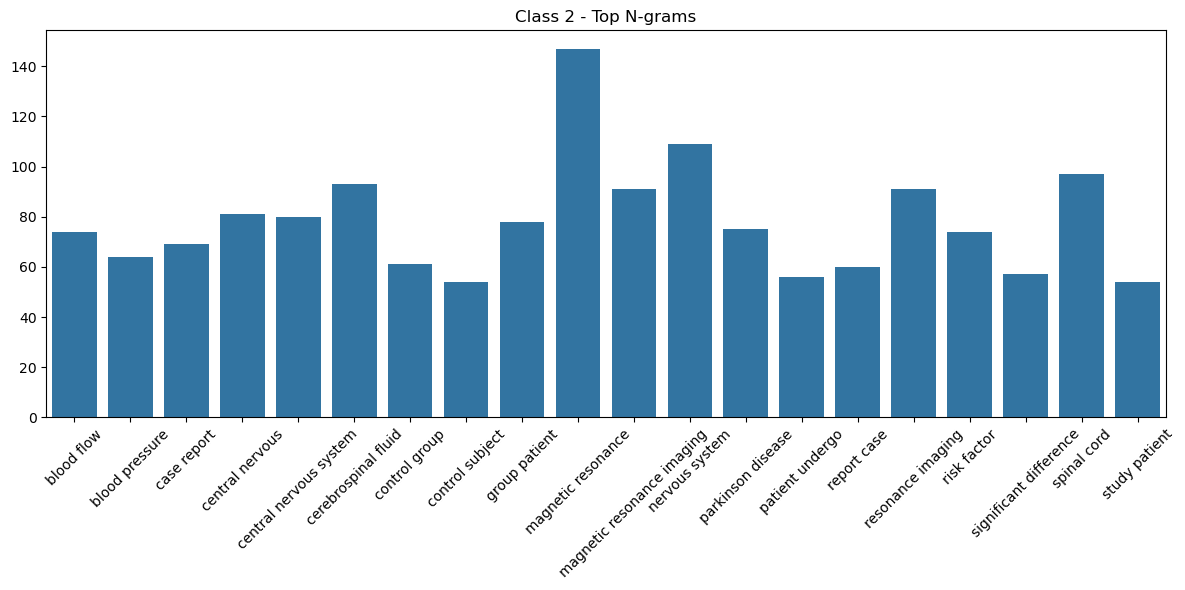

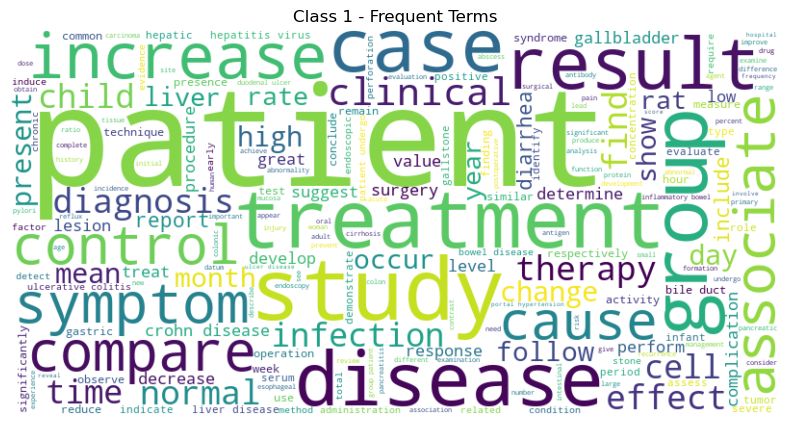

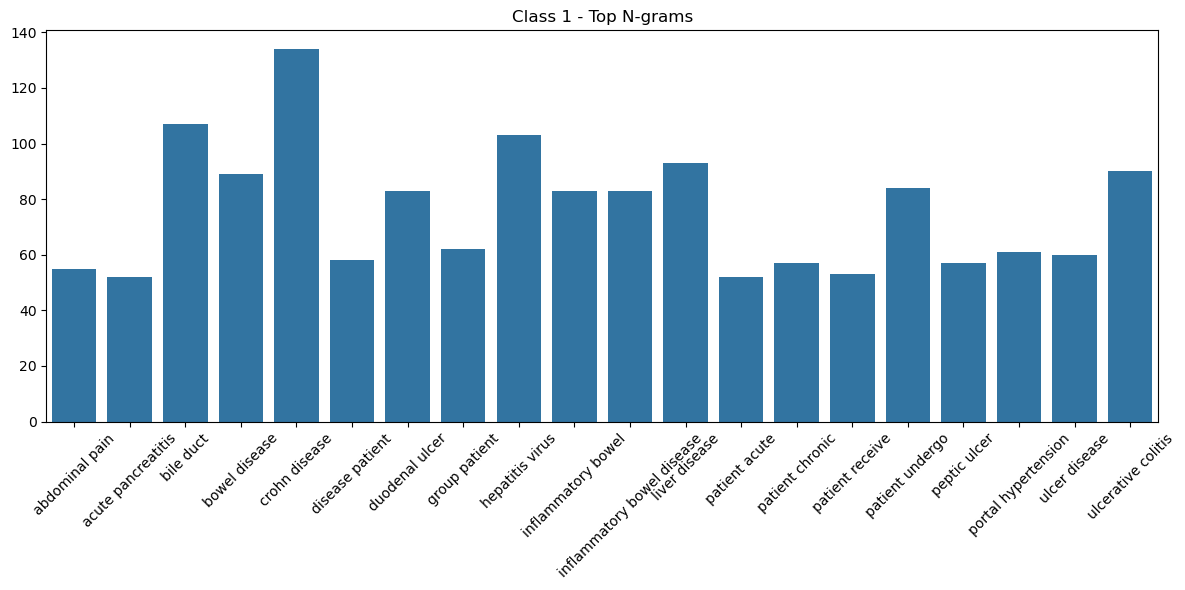

In [11]:
def generate_eda(df, class_label):
    # Word Cloud for the given class
    text = " ".join(df[df['class'] == class_label]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Class {class_label} - Frequent Terms")
    plt.axis("off")
    plt.show()
    
    # N-gram Analysis using CountVectorizer (2-grams and 3-grams)
    cv = CountVectorizer(ngram_range=(2,3), max_features=20)
    # We filter to the texts for the given class
    class_texts = df[df['class'] == class_label]['clean_text']
    ngrams = cv.fit_transform(class_texts)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cv.get_feature_names_out(), y=ngrams.sum(axis=0).A1)
    plt.xticks(rotation=45)
    plt.title(f"Class {class_label} - Top N-grams")
    plt.tight_layout()
    plt.show()

print("\nGenerating EDA visuals...")
for label in train_df['class'].unique():
    generate_eda(train_df, label)

## 4. Feature Engineering with TF-IDF

In [4]:
def create_tfidf_features(train_text, val_text, test_text):
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,3),
        stop_words='english',
        sublinear_tf=True
    )
    X_train = tfidf.fit_transform(train_text)
    X_val = tfidf.transform(val_text)
    X_test = tfidf.transform(test_text)
    return X_train, X_val, X_test, tfidf

print("\nExtracting TF-IDF features...")
X_train, X_val, X_test, tfidf = create_tfidf_features(
    train_df['clean_text'],
    val_df['clean_text'],
    test_df['clean_text']
)
y_train = train_df['class']
y_val = val_df['class']


Extracting TF-IDF features...


## 5. Handling Class Imbalance with SMOTE

In [40]:
print("\nHandling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Handling class imbalance with SMOTE...


## 6. Training Multiple Models and Evaluating Them

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# -------------------------------
# Train Logistic Regression
# -------------------------------
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='saga'
)
lr_model.fit(X_train_smote, y_train_smote)
lr_val_preds = lr_model.predict(X_val)

try:
    lr_y_score = lr_model.predict_proba(X_val)
    lr_roc_auc = roc_auc_score(y_val, lr_y_score, multi_class='ovr')
except AttributeError:
    lr_roc_auc = None

lr_accuracy = accuracy_score(y_val, lr_val_preds)
lr_f1 = f1_score(y_val, lr_val_preds, average='macro')

Training Logistic Regression...


In [7]:
# -------------------------------
# Train Random Forest
# -------------------------------
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=10
)
rf_model.fit(X_train_smote, y_train_smote)
rf_val_preds = rf_model.predict(X_val)

try:
    rf_y_score = rf_model.predict_proba(X_val)
    rf_roc_auc = roc_auc_score(y_val, rf_y_score, multi_class='ovr')
except AttributeError:
    rf_roc_auc = None

rf_accuracy = accuracy_score(y_val, rf_val_preds)
rf_f1 = f1_score(y_val, rf_val_preds, average='macro')

Training Random Forest...


In [27]:
# -------------------------------
# Compile the Results Individually
# -------------------------------
results_lr = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'accuracy': [lr_accuracy],
    'f1': [lr_f1],
    'roc_auc': [lr_roc_auc]
})

results_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'accuracy': [rf_accuracy],
    'f1': [rf_f1],
    'roc_auc': [rf_roc_auc]
})

# Concatenate results from all models
results = pd.concat([results_lr, results_rf], ignore_index=True)

# Sort by ROC AUC in descending order (if roc_auc is available)
results_sorted = results.sort_values('roc_auc', ascending=False)
print("\nValidation Results:")
print(results_sorted)

# -------------------------------
# Select the Best Model Based on ROC AUC
# -------------------------------
if results_sorted.iloc[0]['Model'] == 'Logistic Regression':
    best_model = lr_model
elif results_sorted.iloc[0]['Model'] == 'Random Forest':
    best_model = rf_model

print(f"\nBest model selected: {results_sorted.iloc[0]['Model']}")


Validation Results:
                 Model  accuracy        f1   roc_auc
0  Logistic Regression  0.595238  0.602615  0.860482
1        Random Forest  0.584848  0.590219  0.842064

Best model selected: Logistic Regression


In [ ]:
print("\nFinal Test Evaluation:")
# Generate predictions on the test set using the best model
test_preds = best_model.predict(X_test)
try:
    # Get the full probability array for all classes
    test_probs = best_model.predict_proba(X_test)
except AttributeError:
    test_probs = None

# Print a detailed classification report for the test set
print(classification_report(test_df['class'], test_preds))

if test_probs is not None:
    print(f"ROC AUC: {roc_auc_score(test_df['class'], test_probs, multi_class='ovr'):.3f}")

## 7. Clinical Topic Modeling Using LDA

In [8]:
def clinical_topic_modeling(texts, num_topics=5):
    processed = [text.split() for text in texts]
    dictionary = Dictionary(processed)
    corpus = [dictionary.doc2bow(text) for text in processed]
    
    lda = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        random_state=42
    )
    return lda.print_topics(num_words=8)

print("\nPerforming topic modeling...")
topics = clinical_topic_modeling(train_df['clean_text'])
print("\nIdentified Topics:")
for topic in topics:
    print(topic)


Performing topic modeling...

Identified Topics:
(0, '0.014*"patient" + 0.010*"study" + 0.010*"disease" + 0.006*"syndrome" + 0.006*"risk" + 0.006*"case" + 0.006*"child" + 0.005*"factor"')
(1, '0.024*"patient" + 0.007*"study" + 0.005*"pain" + 0.005*"nerve" + 0.005*"case" + 0.005*"injury" + 0.004*"result" + 0.003*"change"')
(2, '0.025*"cell" + 0.019*"patient" + 0.014*"tumor" + 0.007*"study" + 0.006*"human" + 0.005*"carcinoma" + 0.005*"cancer" + 0.005*"case"')
(3, '0.019*"patient" + 0.011*"group" + 0.011*"ventricular" + 0.009*"heart" + 0.008*"pressure" + 0.008*"increase" + 0.008*"blood" + 0.008*"study"')
(4, '0.053*"patient" + 0.009*"disease" + 0.008*"group" + 0.007*"year" + 0.007*"case" + 0.007*"treatment" + 0.005*"surgery" + 0.005*"study"')


## 8. Final Test Evaluation and Saving Results

In [20]:
print("\nFinal Test Evaluation:")
# Generate predictions on the test set using the best model
test_preds = best_model.predict(X_test)
try:
    # Get the full probability array for all classes
    test_probs = best_model.predict_proba(X_test)
except AttributeError:
    test_probs = None

# Print a detailed classification report for the test set
print(classification_report(test_df['class'], test_preds))

if test_probs is not None:
    print(f"ROC AUC: {roc_auc_score(test_df['class'], test_probs, multi_class='ovr'):.3f}")


Final Test Evaluation:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       667
           1       0.49      0.67      0.57       295
           2       0.43      0.57      0.49       336
           3       0.66      0.71      0.68       625
           4       0.55      0.39      0.46       965

    accuracy                           0.59      2888
   macro avg       0.57      0.61      0.58      2888
weighted avg       0.59      0.59      0.58      2888

ROC AUC: 0.862


<Figure size 800x600 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

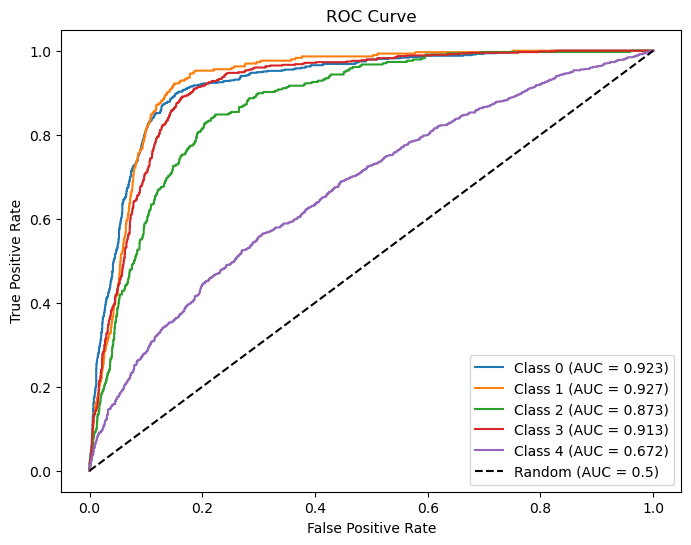

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Check if probabilities exist
if test_probs is not None:
    n_classes = test_probs.shape[1]  # Number of classes
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_df['class'] == i, test_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

    # Plot the diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve cannot be plotted as `predict_proba` is not available.")
